In [1]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

/home/team4/anaconda3/envs/gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/team4/anaconda3/envs/gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/team4/anaconda3/envs/gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/team4/anaconda3/envs/gpu/lib/python3.7/site-packages

In [4]:
import keras
import pandas as pd
import tensorflow as tf

import numpy as np
# from keras.models import Sequential, Model
# from keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import np_utils

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D, Input,AveragePooling2D, BatchNormalization, LeakyReLU, SpatialDropout2D

# from keras.applications import MobileNet
# from keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2, InceptionV3
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot as plt
import os
from sklearn.model_selection import train_test_split

import seaborn as sns
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import KFold

from collections import defaultdict,Counter
from imblearn.over_sampling import SMOTE
from PIL import Image

from kerastuner import HyperModel

Using TensorFlow backend.


<h2>Data Loading and Preparation</h2>

In [5]:
def getSpeciesCode(x):
    part = x.split('_')
    if part[0] == 'ASETRI':
        return 0
    elif part[0] == 'EPTBOT':
        return 1
    elif part[0] == 'MYOEMA':
        return 2
    elif part[0] == 'PIPKUH':
        return 3
    elif part[0] == 'RHIMUS':
        return 4
    elif part[0] == 'RHYNAS':
        return 5
    elif part[0] == 'ROUAEG':
        return 6
    elif part[0] == 'TAPPER':
        return 7
    else:
        return 'Unknown'
    
def getSpecies(x):
    if x == 0:
        return 'A.tridens'
    elif x == 1:
        return 'E.bottae'
    elif x == 2:
        return 'M.emarginatus'
    elif x == 3:
        return 'P.kuhli'
    elif x == 4:
        return 'R.muscatellum'
    elif x == 5:
        return 'R.nasutus'
    elif x == 6:
        return 'R.aegyptius'
    elif x == 7:
        return 'T.perforatus'
    else:
        return 'Unknown'
    
    
def generate_actual_predicted(Y_pred, X_test, Y_test): 
    predicted = list()
    for i in range(len(Y_pred)):
        predicted.append(np.argmax(Y_pred[i]))
        
    actual = list()
    for i in range(len(Y_test)):
        actual.append(np.argmax(Y_test[i]))
        
    return actual, predicted


# Ytrain in Onehot encoded form 
def makeOverSamplesSMOTE(X_train,Y_train):
    
    Y_train_labelled=[]
    X_dims=X_train.shape

    for i in range(len(Y_train)):
        Y_train_labelled.append(np.argmax(Y_train[i]))

    print('Original trainingset shape %s' %  [(getSpecies(k),v) for k,v in Counter(Y_train_labelled).items()])       
    X_train= X_train.reshape(-1,X_dims[1]*X_dims[2]*X_dims[3])

    sm = SMOTE(sampling_strategy='all',k_neighbors=5)
    X_train, Y_train_labelled = sm.fit_resample(X_train, Y_train_labelled)


    print('Resampled training set shape %s' % [(getSpecies(k),v) for k,v in Counter(Y_train_labelled).items()])


    #reshape X_all
    X_train= X_train.reshape(-1,X_dims[1],X_dims[2],X_dims[3])

    # update Y_train
    Y_train= np_utils.to_categorical(Y_train_labelled, num_classes=8)

    print("After OverSampling\nX_train: shape= ",X_train.shape)
    print("Y_train: shape= ",Y_train.shape)

    
    
    return(X_train,Y_train)

In [6]:
image_folder_path = '../data/refspec'
file_paths = [f for f in os.listdir(image_folder_path)]
species = []
for file_name in file_paths:
    sp = file_name.split('_')
    species.append(sp[0])

df = pd.DataFrame(species, columns=['Species'])
df['Species'].value_counts()

RHIMUS    1665
TAPPER     403
PIPKUH     299
RHYNAS     269
EPTBOT     124
ROUAEG     121
MYOEMA     112
ASETRI      25
Name: Species, dtype: int64

In [7]:
X_all = []
Y_all = []

image_folder_path = '../data/refspec'
file_paths = [f for f in os.listdir(image_folder_path)]

for file_name in file_paths:
    spectrogram = Image.open(image_folder_path + '/' + file_name)
    spectrogram = spectrogram.convert('RGB')
    spectrogram = spectrogram.resize((170, 112))  
    spectrogram = np.array(spectrogram)
    #spectrogram = np.expand_dims(spectrogram, axis=2) 
    X_all.append(spectrogram)
    Y_all.append(getSpeciesCode(file_name))


In [8]:
X_all = np.array(X_all)
Y_all = np.array(Y_all)

print(X_all.shape)
print(Y_all.shape)

X_all = X_all.astype('float32')
X_all /= 255

Y_all = np_utils.to_categorical(Y_all, num_classes=8) 


(3018, 112, 170, 3)
(3018,)


In [9]:
# train /test= 80/20% split
# Data is stratified
X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_all, test_size=0.2, random_state = 245, stratify=Y_all)

X_train, Y_train= makeOverSamplesSMOTE(X_train, Y_train)

Original trainingset shape [('R.aegyptius', 97), ('R.muscatellum', 1332), ('R.nasutus', 215), ('E.bottae', 99), ('P.kuhli', 239), ('T.perforatus', 322), ('M.emarginatus', 90), ('A.tridens', 20)]
Resampled training set shape [('R.aegyptius', 1332), ('R.muscatellum', 1332), ('R.nasutus', 1332), ('E.bottae', 1332), ('P.kuhli', 1332), ('T.perforatus', 1332), ('M.emarginatus', 1332), ('A.tridens', 1332)]
After OverSampling
X_train: shape=  (10656, 112, 170, 3)
Y_train: shape=  (10656, 8)


<h2>Keras Tuner</h2>

In [58]:
class CNNHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):        
        inp = Input(shape=self.input_shape)
        lay = Convolution2D(filters=hp.Int('conv1', min_value=16, max_value=256, step=16, default=128),kernel_size=(7,7),strides=(2,2),padding='same')(inp)
        lay = BatchNormalization()(lay)
        lay = Activation('relu')(lay)
        lay = MaxPooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
        lay = SpatialDropout2D(0.06)(lay)

        lay = Convolution2D(filters=hp.Int('conv2', min_value=16, max_value=256, step=16, default=128),kernel_size=(5,5),strides=(2,2),padding='same')(lay)
        lay = BatchNormalization()(lay)
        lay = Activation('relu')(lay)
        lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
        lay = SpatialDropout2D(0.06)(lay)
        
        lay = Convolution2D(filters=hp.Int('conv3', min_value=16, max_value=256, step=16, default=128),kernel_size=(3,3),strides=(1,1),padding='same')(lay)
        lay = BatchNormalization()(lay)
        lay = Activation('relu')(lay)
        lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
        lay = SpatialDropout2D(0.02)(lay)
        
        lay = Convolution2D(filters=hp.Int('conv4', min_value=16, max_value=256, step=16, default=128),kernel_size=(3,3),strides=(1,1),padding='same')(lay)
        lay = BatchNormalization()(lay)
        lay = Activation('relu')(lay)
        lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
        lay = SpatialDropout2D(0.02)(lay)

        lay = Flatten()(lay)

        lay = Dense(hp.Int('dense1', min_value=32, max_value=256, step=16, default=64))(lay)
        lay = BatchNormalization()(lay)
        lay = Activation('relu')(lay)
        lay = Dropout(0.15)(lay)
        
        lay = Dense(hp.Int('dense2', min_value=32, max_value=256, step=16, default=64))(lay)
        lay = BatchNormalization()(lay)
        lay = Activation('relu')(lay)
        lay = Dropout(0.15)(lay)
        
        lay = Dense(hp.Int('dense3', min_value=32, max_value=256, step=16, default=64))(lay)
        lay = BatchNormalization()(lay)
        lay = Activation('relu')(lay)
        lay = Dropout(0.15)(lay)

        x_out = Dense(8, name='output', activation='softmax')(lay)
        model = Model(inputs=inp, outputs=x_out)
        model.compile(
            optimizer=Adam(lr=0.003),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        return model

In [59]:
from kerastuner.tuners import RandomSearch

hypermodel = CNNHyperModel(input_shape=(108,167,3), num_classes=8)

tuner = RandomSearch(
    hypermodel,
    objective='val_acc',
    max_trials=10,
    executions_per_trial=2,
    directory='random_search',
    project_name='bat',
    overwrite=True
)

In [60]:
tuner.search(X_train, Y_train, epochs=70, validation_split=0.1, batch_size=8, verbose=2)

Train on 2172 samples, validate on 242 samples
Epoch 1/70
2172/2172 - 6s - loss: 1.5728 - acc: 0.5064 - val_loss: 1.4680 - val_acc: 0.5413
Epoch 2/70
2172/2172 - 5s - loss: 1.4161 - acc: 0.5345 - val_loss: 2.0503 - val_acc: 0.4215
Epoch 3/70
2172/2172 - 5s - loss: 1.3759 - acc: 0.5516 - val_loss: 1.3102 - val_acc: 0.6074
Epoch 4/70
2172/2172 - 5s - loss: 1.3238 - acc: 0.5631 - val_loss: 1.3220 - val_acc: 0.6157
Epoch 5/70
2172/2172 - 5s - loss: 1.2674 - acc: 0.5704 - val_loss: 1.5299 - val_acc: 0.5579
Epoch 6/70
2172/2172 - 5s - loss: 1.2122 - acc: 0.5925 - val_loss: 1.5034 - val_acc: 0.6157
Epoch 7/70
2172/2172 - 5s - loss: 1.0905 - acc: 0.6165 - val_loss: 1.4077 - val_acc: 0.5372
Epoch 8/70
2172/2172 - 5s - loss: 1.0605 - acc: 0.6446 - val_loss: 1.0012 - val_acc: 0.6777
Epoch 9/70
2172/2172 - 5s - loss: 0.9727 - acc: 0.6657 - val_loss: 1.2056 - val_acc: 0.6405
Epoch 10/70
2172/2172 - 5s - loss: 0.9153 - acc: 0.6920 - val_loss: 0.9380 - val_acc: 0.6983
Epoch 11/70
2172/2172 - 5s - los

Epoch 19/70
2172/2172 - 5s - loss: 0.5897 - acc: 0.7951 - val_loss: 0.5272 - val_acc: 0.8017
Epoch 20/70
2172/2172 - 5s - loss: 0.5710 - acc: 0.8043 - val_loss: 0.8270 - val_acc: 0.7314
Epoch 21/70
2172/2172 - 5s - loss: 0.5842 - acc: 0.8076 - val_loss: 0.4669 - val_acc: 0.8017
Epoch 22/70
2172/2172 - 5s - loss: 0.5826 - acc: 0.8029 - val_loss: 0.9831 - val_acc: 0.7521
Epoch 23/70
2172/2172 - 5s - loss: 0.5620 - acc: 0.8108 - val_loss: 0.6602 - val_acc: 0.7851
Epoch 24/70
2172/2172 - 5s - loss: 0.5680 - acc: 0.8122 - val_loss: 0.6774 - val_acc: 0.7727
Epoch 25/70
2172/2172 - 5s - loss: 0.5633 - acc: 0.8214 - val_loss: 0.4935 - val_acc: 0.8471
Epoch 26/70
2172/2172 - 5s - loss: 0.5055 - acc: 0.8273 - val_loss: 0.8976 - val_acc: 0.6818
Epoch 27/70
2172/2172 - 5s - loss: 0.4768 - acc: 0.8320 - val_loss: 0.5680 - val_acc: 0.7810
Epoch 28/70
2172/2172 - 5s - loss: 0.4893 - acc: 0.8402 - val_loss: 0.4993 - val_acc: 0.8264
Epoch 29/70
2172/2172 - 5s - loss: 0.4616 - acc: 0.8343 - val_loss: 0.

Train on 2172 samples, validate on 242 samples
Epoch 1/70
2172/2172 - 4s - loss: 1.5748 - acc: 0.5147 - val_loss: 1.5732 - val_acc: 0.5868
Epoch 2/70
2172/2172 - 3s - loss: 1.4533 - acc: 0.5442 - val_loss: 1.5203 - val_acc: 0.5868
Epoch 3/70
2172/2172 - 3s - loss: 1.3699 - acc: 0.5585 - val_loss: 1.3249 - val_acc: 0.6198
Epoch 4/70
2172/2172 - 3s - loss: 1.3308 - acc: 0.5691 - val_loss: 1.6511 - val_acc: 0.4876
Epoch 5/70
2172/2172 - 3s - loss: 1.2516 - acc: 0.5737 - val_loss: 1.6937 - val_acc: 0.6198
Epoch 6/70
2172/2172 - 3s - loss: 1.1624 - acc: 0.5985 - val_loss: 1.1159 - val_acc: 0.6529
Epoch 7/70
2172/2172 - 3s - loss: 1.1096 - acc: 0.6082 - val_loss: 1.0170 - val_acc: 0.6777
Epoch 8/70
2172/2172 - 3s - loss: 1.0257 - acc: 0.6441 - val_loss: 1.0742 - val_acc: 0.5785
Epoch 9/70
2172/2172 - 3s - loss: 0.9149 - acc: 0.6832 - val_loss: 0.7953 - val_acc: 0.7273
Epoch 10/70
2172/2172 - 3s - loss: 0.8817 - acc: 0.6966 - val_loss: 0.8332 - val_acc: 0.7355
Epoch 11/70
2172/2172 - 3s - los

Epoch 19/70
2172/2172 - 3s - loss: 0.6214 - acc: 0.8048 - val_loss: 0.4457 - val_acc: 0.8554
Epoch 20/70
2172/2172 - 3s - loss: 0.5678 - acc: 0.8158 - val_loss: 0.4073 - val_acc: 0.8430
Epoch 21/70
2172/2172 - 3s - loss: 0.5755 - acc: 0.8112 - val_loss: 0.4178 - val_acc: 0.8719
Epoch 22/70
2172/2172 - 3s - loss: 0.5363 - acc: 0.8172 - val_loss: 0.9569 - val_acc: 0.6983
Epoch 23/70
2172/2172 - 3s - loss: 0.5094 - acc: 0.8393 - val_loss: 0.3960 - val_acc: 0.8430
Epoch 24/70
2172/2172 - 3s - loss: 0.5180 - acc: 0.8347 - val_loss: 0.7443 - val_acc: 0.6860
Epoch 25/70
2172/2172 - 3s - loss: 0.4970 - acc: 0.8301 - val_loss: 0.5613 - val_acc: 0.8017
Epoch 26/70
2172/2172 - 3s - loss: 0.4818 - acc: 0.8444 - val_loss: 0.4167 - val_acc: 0.8388
Epoch 27/70
2172/2172 - 3s - loss: 0.4808 - acc: 0.8412 - val_loss: 0.5115 - val_acc: 0.8017
Epoch 28/70
2172/2172 - 3s - loss: 0.4702 - acc: 0.8430 - val_loss: 0.4358 - val_acc: 0.8554
Epoch 29/70
2172/2172 - 3s - loss: 0.4597 - acc: 0.8564 - val_loss: 0.

Train on 2172 samples, validate on 242 samples
Epoch 1/70
2172/2172 - 5s - loss: 1.6033 - acc: 0.5005 - val_loss: 1.8850 - val_acc: 0.3017
Epoch 2/70
2172/2172 - 4s - loss: 1.4339 - acc: 0.5424 - val_loss: 1.4887 - val_acc: 0.5868
Epoch 3/70
2172/2172 - 4s - loss: 1.3274 - acc: 0.5640 - val_loss: 1.3610 - val_acc: 0.6074
Epoch 4/70
2172/2172 - 5s - loss: 1.2754 - acc: 0.5718 - val_loss: 3.3398 - val_acc: 0.5868
Epoch 5/70
2172/2172 - 4s - loss: 1.2179 - acc: 0.5884 - val_loss: 1.1641 - val_acc: 0.6322
Epoch 6/70
2172/2172 - 5s - loss: 1.1146 - acc: 0.6192 - val_loss: 1.4655 - val_acc: 0.3802
Epoch 7/70
2172/2172 - 5s - loss: 1.0297 - acc: 0.6441 - val_loss: 0.9394 - val_acc: 0.6529
Epoch 8/70
2172/2172 - 4s - loss: 0.9594 - acc: 0.6538 - val_loss: 0.8626 - val_acc: 0.7190
Epoch 9/70
2172/2172 - 4s - loss: 0.8621 - acc: 0.7067 - val_loss: 0.9818 - val_acc: 0.6570
Epoch 10/70
2172/2172 - 4s - loss: 0.8140 - acc: 0.7150 - val_loss: 1.2001 - val_acc: 0.5992
Epoch 11/70
2172/2172 - 5s - los

Epoch 19/70
2172/2172 - 4s - loss: 0.5527 - acc: 0.8126 - val_loss: 1.0143 - val_acc: 0.6322
Epoch 20/70
2172/2172 - 4s - loss: 0.5337 - acc: 0.8094 - val_loss: 0.4839 - val_acc: 0.8264
Epoch 21/70
2172/2172 - 4s - loss: 0.5577 - acc: 0.8163 - val_loss: 0.4717 - val_acc: 0.8306
Epoch 22/70
2172/2172 - 4s - loss: 0.5186 - acc: 0.8260 - val_loss: 0.6886 - val_acc: 0.7727
Epoch 23/70
2172/2172 - 5s - loss: 0.4931 - acc: 0.8347 - val_loss: 0.4898 - val_acc: 0.8264
Epoch 24/70
2172/2172 - 4s - loss: 0.4892 - acc: 0.8347 - val_loss: 0.7138 - val_acc: 0.7438
Epoch 25/70
2172/2172 - 4s - loss: 0.4684 - acc: 0.8416 - val_loss: 0.4570 - val_acc: 0.8471
Epoch 26/70
2172/2172 - 4s - loss: 0.4597 - acc: 0.8430 - val_loss: 0.6763 - val_acc: 0.7521
Epoch 27/70
2172/2172 - 4s - loss: 0.4676 - acc: 0.8444 - val_loss: 0.5391 - val_acc: 0.8058
Epoch 28/70
2172/2172 - 4s - loss: 0.3987 - acc: 0.8656 - val_loss: 0.3162 - val_acc: 0.8802
Epoch 29/70
2172/2172 - 4s - loss: 0.4464 - acc: 0.8522 - val_loss: 0.

Train on 2172 samples, validate on 242 samples
Epoch 1/70
2172/2172 - 5s - loss: 1.5979 - acc: 0.5170 - val_loss: 2.4100 - val_acc: 0.5868
Epoch 2/70
2172/2172 - 4s - loss: 1.4698 - acc: 0.5359 - val_loss: 1.5396 - val_acc: 0.5868
Epoch 3/70
2172/2172 - 4s - loss: 1.4183 - acc: 0.5396 - val_loss: 1.2640 - val_acc: 0.5909
Epoch 4/70
2172/2172 - 4s - loss: 1.3776 - acc: 0.5599 - val_loss: 1.8038 - val_acc: 0.4917
Epoch 5/70
2172/2172 - 4s - loss: 1.3024 - acc: 0.5723 - val_loss: 1.3180 - val_acc: 0.6281
Epoch 6/70
2172/2172 - 4s - loss: 1.2211 - acc: 0.5912 - val_loss: 1.3221 - val_acc: 0.6322
Epoch 7/70
2172/2172 - 4s - loss: 1.0879 - acc: 0.6262 - val_loss: 1.8766 - val_acc: 0.1033
Epoch 8/70
2172/2172 - 4s - loss: 0.9799 - acc: 0.6703 - val_loss: 1.2382 - val_acc: 0.5909
Epoch 9/70
2172/2172 - 4s - loss: 0.9055 - acc: 0.6961 - val_loss: 2.1716 - val_acc: 0.2727
Epoch 10/70
2172/2172 - 4s - loss: 0.7857 - acc: 0.7293 - val_loss: 0.8451 - val_acc: 0.6983
Epoch 11/70
2172/2172 - 4s - los

Epoch 19/70
2172/2172 - 3s - loss: 0.5201 - acc: 0.8246 - val_loss: 0.6797 - val_acc: 0.7851
Epoch 20/70
2172/2172 - 3s - loss: 0.5672 - acc: 0.8103 - val_loss: 0.6030 - val_acc: 0.7893
Epoch 21/70
2172/2172 - 3s - loss: 0.5536 - acc: 0.8168 - val_loss: 0.4208 - val_acc: 0.8388
Epoch 22/70
2172/2172 - 3s - loss: 0.4590 - acc: 0.8412 - val_loss: 0.5813 - val_acc: 0.7686
Epoch 23/70
2172/2172 - 3s - loss: 0.4909 - acc: 0.8324 - val_loss: 0.6656 - val_acc: 0.7769
Epoch 24/70
2172/2172 - 3s - loss: 0.4890 - acc: 0.8384 - val_loss: 0.6160 - val_acc: 0.7769
Epoch 25/70
2172/2172 - 3s - loss: 0.4923 - acc: 0.8393 - val_loss: 0.3050 - val_acc: 0.9008
Epoch 26/70
2172/2172 - 4s - loss: 0.4444 - acc: 0.8554 - val_loss: 0.7800 - val_acc: 0.8017
Epoch 27/70
2172/2172 - 3s - loss: 0.4919 - acc: 0.8375 - val_loss: 0.6908 - val_acc: 0.7727
Epoch 28/70
2172/2172 - 3s - loss: 0.4450 - acc: 0.8605 - val_loss: 0.8751 - val_acc: 0.6942
Epoch 29/70
2172/2172 - 3s - loss: 0.4194 - acc: 0.8711 - val_loss: 0.

Train on 2172 samples, validate on 242 samples
Epoch 1/70
2172/2172 - 3s - loss: 1.5723 - acc: 0.5152 - val_loss: 2.0636 - val_acc: 0.5537
Epoch 2/70
2172/2172 - 2s - loss: 1.4187 - acc: 0.5456 - val_loss: 1.7174 - val_acc: 0.5702
Epoch 3/70
2172/2172 - 2s - loss: 1.3567 - acc: 0.5483 - val_loss: 1.3495 - val_acc: 0.5909
Epoch 4/70
2172/2172 - 2s - loss: 1.2540 - acc: 0.5769 - val_loss: 1.2303 - val_acc: 0.6074
Epoch 5/70
2172/2172 - 2s - loss: 1.1762 - acc: 0.6031 - val_loss: 1.3390 - val_acc: 0.5124
Epoch 6/70
2172/2172 - 2s - loss: 1.0654 - acc: 0.6381 - val_loss: 1.3556 - val_acc: 0.5868
Epoch 7/70
2172/2172 - 2s - loss: 0.9387 - acc: 0.6805 - val_loss: 1.0077 - val_acc: 0.6570
Epoch 8/70
2172/2172 - 2s - loss: 0.8849 - acc: 0.7081 - val_loss: 1.4020 - val_acc: 0.4504
Epoch 9/70
2172/2172 - 2s - loss: 0.7991 - acc: 0.7288 - val_loss: 0.8189 - val_acc: 0.7479
Epoch 10/70
2172/2172 - 2s - loss: 0.7524 - acc: 0.7518 - val_loss: 1.0375 - val_acc: 0.6405
Epoch 11/70
2172/2172 - 2s - los

Epoch 19/70
2172/2172 - 2s - loss: 0.5541 - acc: 0.8181 - val_loss: 0.6790 - val_acc: 0.7686
Epoch 20/70
2172/2172 - 2s - loss: 0.5716 - acc: 0.8149 - val_loss: 0.4995 - val_acc: 0.8182
Epoch 21/70
2172/2172 - 2s - loss: 0.5106 - acc: 0.8264 - val_loss: 0.4857 - val_acc: 0.8264
Epoch 22/70
2172/2172 - 2s - loss: 0.5252 - acc: 0.8232 - val_loss: 0.3502 - val_acc: 0.8595
Epoch 23/70
2172/2172 - 2s - loss: 0.5107 - acc: 0.8287 - val_loss: 0.5908 - val_acc: 0.7893
Epoch 24/70
2172/2172 - 2s - loss: 0.4843 - acc: 0.8370 - val_loss: 0.6043 - val_acc: 0.7934
Epoch 25/70
2172/2172 - 2s - loss: 0.4919 - acc: 0.8389 - val_loss: 0.3880 - val_acc: 0.8678
Epoch 26/70
2172/2172 - 2s - loss: 0.4785 - acc: 0.8393 - val_loss: 0.3725 - val_acc: 0.8554
Epoch 27/70
2172/2172 - 2s - loss: 0.4819 - acc: 0.8343 - val_loss: 0.8468 - val_acc: 0.6777
Epoch 28/70
2172/2172 - 2s - loss: 0.4537 - acc: 0.8531 - val_loss: 0.7145 - val_acc: 0.7727
Epoch 29/70
2172/2172 - 2s - loss: 0.4813 - acc: 0.8398 - val_loss: 0.

Train on 2172 samples, validate on 242 samples
Epoch 1/70
2172/2172 - 5s - loss: 1.5470 - acc: 0.5281 - val_loss: 1.4474 - val_acc: 0.5868
Epoch 2/70
2172/2172 - 4s - loss: 1.4410 - acc: 0.5396 - val_loss: 1.3956 - val_acc: 0.5289
Epoch 3/70
2172/2172 - 5s - loss: 1.3501 - acc: 0.5571 - val_loss: 1.3576 - val_acc: 0.5868
Epoch 4/70
2172/2172 - 5s - loss: 1.2841 - acc: 0.5723 - val_loss: 1.5506 - val_acc: 0.6074
Epoch 5/70
2172/2172 - 5s - loss: 1.2268 - acc: 0.5829 - val_loss: 1.3538 - val_acc: 0.5950
Epoch 6/70
2172/2172 - 5s - loss: 1.1184 - acc: 0.6096 - val_loss: 2.0116 - val_acc: 0.5826
Epoch 7/70
2172/2172 - 5s - loss: 1.0479 - acc: 0.6340 - val_loss: 1.1062 - val_acc: 0.6612
Epoch 8/70
2172/2172 - 4s - loss: 0.9597 - acc: 0.6625 - val_loss: 1.4202 - val_acc: 0.5992
Epoch 9/70
2172/2172 - 5s - loss: 0.9255 - acc: 0.6865 - val_loss: 1.3536 - val_acc: 0.4174
Epoch 10/70
2172/2172 - 5s - loss: 0.8408 - acc: 0.7122 - val_loss: 0.7688 - val_acc: 0.7314
Epoch 11/70
2172/2172 - 5s - los

Epoch 19/70
2172/2172 - 4s - loss: 0.6085 - acc: 0.7887 - val_loss: 0.6659 - val_acc: 0.7479
Epoch 20/70
2172/2172 - 4s - loss: 0.5778 - acc: 0.8076 - val_loss: 0.7951 - val_acc: 0.7149
Epoch 21/70
2172/2172 - 4s - loss: 0.5518 - acc: 0.8108 - val_loss: 1.0849 - val_acc: 0.5124
Epoch 22/70
2172/2172 - 4s - loss: 0.5506 - acc: 0.8122 - val_loss: 0.5128 - val_acc: 0.8388
Epoch 23/70
2172/2172 - 4s - loss: 0.5078 - acc: 0.8260 - val_loss: 0.4309 - val_acc: 0.8471
Epoch 24/70
2172/2172 - 4s - loss: 0.5394 - acc: 0.8218 - val_loss: 0.6070 - val_acc: 0.7893
Epoch 25/70
2172/2172 - 4s - loss: 0.5013 - acc: 0.8393 - val_loss: 0.4353 - val_acc: 0.8099
Epoch 26/70
2172/2172 - 4s - loss: 0.5236 - acc: 0.8264 - val_loss: 0.4599 - val_acc: 0.8512
Epoch 27/70
2172/2172 - 4s - loss: 0.4756 - acc: 0.8324 - val_loss: 0.3159 - val_acc: 0.8926
Epoch 28/70
2172/2172 - 4s - loss: 0.4105 - acc: 0.8679 - val_loss: 0.4475 - val_acc: 0.8347
Epoch 29/70
2172/2172 - 4s - loss: 0.4706 - acc: 0.8435 - val_loss: 0.

Train on 2172 samples, validate on 242 samples
Epoch 1/70
2172/2172 - 4s - loss: 1.6259 - acc: 0.5051 - val_loss: 1.6859 - val_acc: 0.4959
Epoch 2/70
2172/2172 - 4s - loss: 1.4715 - acc: 0.5313 - val_loss: 1.7079 - val_acc: 0.6033
Epoch 3/70
2172/2172 - 4s - loss: 1.3790 - acc: 0.5557 - val_loss: 1.3388 - val_acc: 0.6033
Epoch 4/70
2172/2172 - 3s - loss: 1.2996 - acc: 0.5704 - val_loss: 1.8889 - val_acc: 0.5868
Epoch 5/70
2172/2172 - 3s - loss: 1.1947 - acc: 0.5875 - val_loss: 1.2640 - val_acc: 0.6198
Epoch 6/70
2172/2172 - 4s - loss: 1.0937 - acc: 0.6271 - val_loss: 1.7090 - val_acc: 0.3099
Epoch 7/70
2172/2172 - 3s - loss: 0.9905 - acc: 0.6510 - val_loss: 1.3208 - val_acc: 0.6405
Epoch 8/70
2172/2172 - 4s - loss: 0.8925 - acc: 0.6915 - val_loss: 1.8021 - val_acc: 0.6570
Epoch 9/70
2172/2172 - 3s - loss: 0.8399 - acc: 0.7081 - val_loss: 0.7476 - val_acc: 0.7438
Epoch 10/70
2172/2172 - 3s - loss: 0.7713 - acc: 0.7307 - val_loss: 0.9528 - val_acc: 0.7190
Epoch 11/70
2172/2172 - 3s - los

Epoch 19/70
2172/2172 - 3s - loss: 0.5783 - acc: 0.8112 - val_loss: 0.4856 - val_acc: 0.7686
Epoch 20/70
2172/2172 - 3s - loss: 0.5416 - acc: 0.8181 - val_loss: 0.5143 - val_acc: 0.8058
Epoch 21/70
2172/2172 - 3s - loss: 0.5485 - acc: 0.8209 - val_loss: 0.5554 - val_acc: 0.8140
Epoch 22/70
2172/2172 - 3s - loss: 0.5285 - acc: 0.8260 - val_loss: 1.1022 - val_acc: 0.7066
Epoch 23/70
2172/2172 - 3s - loss: 0.5054 - acc: 0.8278 - val_loss: 0.5866 - val_acc: 0.7686
Epoch 24/70
2172/2172 - 4s - loss: 0.5143 - acc: 0.8315 - val_loss: 0.8151 - val_acc: 0.7438
Epoch 25/70
2172/2172 - 3s - loss: 0.5151 - acc: 0.8195 - val_loss: 0.7300 - val_acc: 0.7810
Epoch 26/70
2172/2172 - 3s - loss: 0.4761 - acc: 0.8458 - val_loss: 0.3093 - val_acc: 0.8967
Epoch 27/70


KeyboardInterrupt: 

In [45]:
tuner.results_summary()

In [46]:
best_model = tuner.get_best_models(num_models=1)[0]
loss, accuracy = best_model.evaluate(X_test, Y_test)

604/604 [==============================] - ETA: 2s - loss: 0.2906 - acc: 0.875 - ETA: 0s - loss: 0.2372 - acc: 0.911 - 0s 360us/sample - loss: 0.2160 - acc: 0.9238


In [47]:
accuracy

0.92384106

In [48]:
best_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 108, 167, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 54, 84, 16)        2368      
_________________________________________________________________
batch_normalization (BatchNo (None, 54, 84, 16)        64        
_________________________________________________________________
activation (Activation)      (None, 54, 84, 16)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 42, 16)        0         
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 27, 42, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 21, 64)        25664 

<h2>Evaluate Best Model</h2>

In [17]:
model = best_model

[[  5   0   0   0   0   0   0   0]
 [  0  25   0   0   0   0   0   0]
 [  0   0  21   1   0   0   0   0]
 [  0   0   1  56   0   2   0   1]
 [  0   1   0   2 327   0   0   3]
 [  0   1   0   3   0  50   0   0]
 [  0   2   2   0   5   0  15   0]
 [  0   0   0   1   1   0   1  78]]


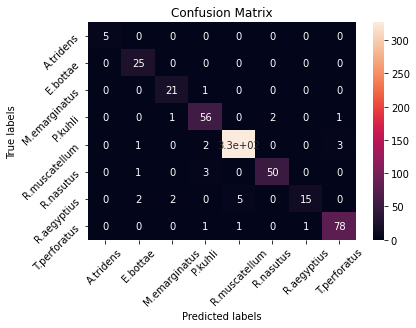

In [18]:
Y_pred = model.predict(X_test)
actual, predicted = generate_actual_predicted(Y_pred, X_test, Y_test)

##Confusion Matrix
from sklearn.metrics import confusion_matrix
actual_labeled = list()
predict_labeled = list()
for x,y in zip(actual,predicted):
    actual_labeled.append(getSpecies(x))
    predict_labeled.append(getSpecies(y))

labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']
cm=confusion_matrix(actual_labeled,predict_labeled,labels=labels)
print(cm)

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);

In [19]:
## Test accuracy
from sklearn.metrics import accuracy_score
print('accuracy', accuracy_score(actual, predicted))


accuracy 0.9552980132450332


In [20]:
## Precision, Recall, F1, Support
from sklearn.metrics import classification_report
print(classification_report(actual_labeled, predict_labeled,labels=labels))

               precision    recall  f1-score   support

    A.tridens       1.00      1.00      1.00         5
     E.bottae       0.86      1.00      0.93        25
M.emarginatus       0.88      0.95      0.91        22
      P.kuhli       0.89      0.93      0.91        60
R.muscatellum       0.98      0.98      0.98       333
    R.nasutus       0.96      0.93      0.94        54
  R.aegyptius       0.94      0.62      0.75        24
 T.perforatus       0.95      0.96      0.96        81

     accuracy                           0.96       604
    macro avg       0.93      0.92      0.92       604
 weighted avg       0.96      0.96      0.95       604



<h2>K-Fold Training and Evaluation</h2>

In [12]:
def build_current_model():
    inp = Input(shape=(112,170,3))
    lay = Convolution2D(filters=56,kernel_size=(7,7),strides=(2,2),padding='same')(inp)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = MaxPooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = Dropout(0.3)(lay)

    lay = Convolution2D(filters=72,kernel_size=(5,5),strides=(2,2),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = Dropout(0.3)(lay)

    lay = Convolution2D(filters=56,kernel_size=(3,3),strides=(1,1),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = Dropout(0.3)(lay)

    lay = Convolution2D(filters=72,kernel_size=(3,3),strides=(1,1),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = Dropout(0.3)(lay)

    lay = Flatten()(lay)

    lay = Dense(48)(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = Dropout(0.15)(lay)

    x_out = Dense(8, name='output', activation='softmax')(lay)
    model = Model(inputs=inp, outputs=x_out)
    model.compile(
        optimizer=Adam(lr=0.003),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [13]:
model = build_current_model()
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 112, 170, 3)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 56, 85, 56)        8288      
_________________________________________________________________
batch_normalization_5 (Batch (None, 56, 85, 56)        224       
_________________________________________________________________
activation_5 (Activation)    (None, 56, 85, 56)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 43, 56)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 28, 43, 56)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 22, 72)        1008

In [16]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.metrics import confusion_matrix

all_base_precision = list()
all_base_recall = list()
all_macro_precision = list()
all_macro_recall = list()
all_f1 = list()
all_macro_f1 = list()


all_tpr = list()
all_fpr = list()
all_precision = list()
all_recall = list()
all_cm=list()
all_accuracy = list()
all_history = list()


n_split=10
n_classes=8

y_all_labelled=[]
for i in range(len(Y_all)):
        y_all_labelled.append(np.argmax(Y_all[i]))
        
my_callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=20,verbose=1, mode='min',restore_best_weights=True)]
       
for train_index,test_index in StratifiedKFold(n_split, shuffle=True, random_state=123).split(X_all,y_all_labelled):  
    # use the index to generate training an testing sets
    x_train,x_test=X_all[train_index],X_all[test_index]
    y_train,y_test=Y_all[train_index],Y_all[test_index]
    
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state = 245, stratify=y_train)
    x_train, y_train= makeOverSamplesSMOTE(x_train, y_train)

           
    # create and fit the model
    cv_model=build_current_model() # lr,dense,cnn
    history = cv_model.fit(x_train, y_train,
              batch_size=8,
              epochs=100,
              validation_data=(x_val, y_val),
              verbose=2,
              callbacks=my_callbacks)
    
    all_history.append(history)

    
    #generate predictions
    y_pred = cv_model.predict(x_test)
    actual, predicted = generate_actual_predicted(y_pred, x_test, y_test)
    
    #calc metrics
    curr_base_prec, curr_base_rec, curr_f1, _ = precision_recall_fscore_support(actual, predicted)
    curr_macro_prec = precision_score(actual, predicted,average='macro')
    curr_macro_rec = recall_score(actual, predicted,average='macro')
    curr_macro_f1 = f1_score(actual, predicted,average='macro')
    
    
    actual_labeled = list()
    predict_labeled = list()
    for x,y in zip(actual,predicted):
        actual_labeled.append(getSpecies(x))
        predict_labeled.append(getSpecies(y))
        
    labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']
    curr_cm=confusion_matrix(actual_labeled,predict_labeled,labels=labels)
    
    curr_fpr = [0] * n_classes
    curr_tpr = [0] * n_classes
    for i in range(n_classes):
        curr_fpr[i], curr_tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])
        
    curr_prec = [0] * n_classes
    curr_rec = [0] * n_classes
    for i in range(n_classes):
        curr_prec[i], curr_rec[i], _ = precision_recall_curve(y_test[:,i], y_pred[:,i])

        
    curr_accuracy = accuracy_score(actual, predicted)
    
    #add to lists
    all_base_precision.append(curr_base_prec)
    all_base_recall.append(curr_base_rec)
    all_macro_precision.append(curr_macro_prec)
    all_macro_recall.append(curr_macro_rec)
    
    all_f1.append(curr_f1)
    all_macro_f1.append(curr_macro_f1)
    
    all_accuracy.append(curr_accuracy)

    
    all_fpr.append(curr_fpr)
    all_tpr.append(curr_tpr)
    all_precision.append(curr_prec)
    all_recall.append(curr_rec)
    all_cm.append(curr_cm)
    
    
    

Original trainingset shape [('R.muscatellum', 1199), ('E.bottae', 89), ('R.nasutus', 194), ('R.aegyptius', 86), ('T.perforatus', 289), ('P.kuhli', 216), ('A.tridens', 18), ('M.emarginatus', 81)]
Resampled training set shape [('R.muscatellum', 1199), ('E.bottae', 1199), ('R.nasutus', 1199), ('R.aegyptius', 1199), ('T.perforatus', 1199), ('P.kuhli', 1199), ('A.tridens', 1199), ('M.emarginatus', 1199)]
After OverSampling
X_train: shape=  (9592, 112, 170, 3)
Y_train: shape=  (9592, 8)
Train on 9592 samples, validate on 544 samples
Epoch 1/100
9592/9592 - 10s - loss: 1.5044 - acc: 0.4269 - val_loss: 1.0585 - val_acc: 0.6654
Epoch 2/100
9592/9592 - 9s - loss: 0.9059 - acc: 0.6617 - val_loss: 0.9852 - val_acc: 0.6397
Epoch 3/100
9592/9592 - 9s - loss: 0.5096 - acc: 0.8257 - val_loss: 0.5456 - val_acc: 0.8107
Epoch 4/100
9592/9592 - 9s - loss: 0.3353 - acc: 0.8894 - val_loss: 0.2834 - val_acc: 0.9007
Epoch 5/100
9592/9592 - 9s - loss: 0.2671 - acc: 0.9153 - val_loss: 0.3015 - val_acc: 0.9136
E

Epoch 12/100
9592/9592 - 11s - loss: 0.1119 - acc: 0.9634 - val_loss: 0.1326 - val_acc: 0.9596
Epoch 13/100
9592/9592 - 11s - loss: 0.1158 - acc: 0.9635 - val_loss: 0.1251 - val_acc: 0.9688
Epoch 14/100
9592/9592 - 11s - loss: 0.1004 - acc: 0.9683 - val_loss: 0.1098 - val_acc: 0.9724
Epoch 15/100
9592/9592 - 10s - loss: 0.0923 - acc: 0.9701 - val_loss: 0.2416 - val_acc: 0.9265
Epoch 16/100
9592/9592 - 11s - loss: 0.0975 - acc: 0.9698 - val_loss: 0.0978 - val_acc: 0.9779
Epoch 17/100
9592/9592 - 11s - loss: 0.0928 - acc: 0.9707 - val_loss: 0.1287 - val_acc: 0.9669
Epoch 18/100
9592/9592 - 11s - loss: 0.0974 - acc: 0.9697 - val_loss: 0.1102 - val_acc: 0.9724
Epoch 19/100
9592/9592 - 11s - loss: 0.0748 - acc: 0.9766 - val_loss: 0.1430 - val_acc: 0.9632
Epoch 20/100
9592/9592 - 10s - loss: 0.0725 - acc: 0.9775 - val_loss: 0.1364 - val_acc: 0.9688
Epoch 21/100
9592/9592 - 11s - loss: 0.0764 - acc: 0.9757 - val_loss: 0.1419 - val_acc: 0.9651
Epoch 22/100
9592/9592 - 11s - loss: 0.0699 - acc:

Epoch 20/100
9592/9592 - 10s - loss: 0.0762 - acc: 0.9761 - val_loss: 0.1618 - val_acc: 0.9522
Epoch 21/100
9592/9592 - 10s - loss: 0.0688 - acc: 0.9786 - val_loss: 0.1372 - val_acc: 0.9596
Epoch 22/100
9592/9592 - 10s - loss: 0.0684 - acc: 0.9789 - val_loss: 0.1395 - val_acc: 0.9596
Epoch 23/100
9592/9592 - 10s - loss: 0.0740 - acc: 0.9785 - val_loss: 0.2854 - val_acc: 0.9375
Epoch 24/100
9592/9592 - 10s - loss: 0.0680 - acc: 0.9795 - val_loss: 0.1393 - val_acc: 0.9651
Epoch 25/100
9592/9592 - 10s - loss: 0.0696 - acc: 0.9797 - val_loss: 0.1026 - val_acc: 0.9743
Epoch 26/100
9592/9592 - 10s - loss: 0.0547 - acc: 0.9834 - val_loss: 0.1717 - val_acc: 0.9596
Epoch 27/100
9592/9592 - 11s - loss: 0.0594 - acc: 0.9814 - val_loss: 0.1558 - val_acc: 0.9651
Epoch 28/100
9592/9592 - 10s - loss: 0.0488 - acc: 0.9852 - val_loss: 0.1593 - val_acc: 0.9651
Epoch 29/100
9592/9592 - 10s - loss: 0.0578 - acc: 0.9821 - val_loss: 0.1234 - val_acc: 0.9688
Epoch 30/100
9592/9592 - 11s - loss: 0.0544 - acc:

Epoch 12/100
9584/9584 - 8s - loss: 0.1210 - acc: 0.9594 - val_loss: 0.1776 - val_acc: 0.9430
Epoch 13/100
9584/9584 - 8s - loss: 0.1048 - acc: 0.9672 - val_loss: 0.1432 - val_acc: 0.9485
Epoch 14/100
9584/9584 - 8s - loss: 0.1064 - acc: 0.9660 - val_loss: 0.1658 - val_acc: 0.9504
Epoch 15/100
9584/9584 - 7s - loss: 0.0966 - acc: 0.9695 - val_loss: 0.1739 - val_acc: 0.9596
Epoch 16/100
9584/9584 - 8s - loss: 0.0887 - acc: 0.9719 - val_loss: 0.1809 - val_acc: 0.9614
Epoch 17/100
9584/9584 - 8s - loss: 0.0859 - acc: 0.9738 - val_loss: 0.1964 - val_acc: 0.9522
Epoch 18/100
9584/9584 - 7s - loss: 0.0899 - acc: 0.9706 - val_loss: 0.1689 - val_acc: 0.9577
Epoch 19/100
9584/9584 - 7s - loss: 0.0782 - acc: 0.9752 - val_loss: 0.1395 - val_acc: 0.9669
Epoch 20/100
9584/9584 - 8s - loss: 0.0685 - acc: 0.9791 - val_loss: 0.1453 - val_acc: 0.9669
Epoch 21/100
9584/9584 - 8s - loss: 0.0693 - acc: 0.9770 - val_loss: 0.1266 - val_acc: 0.9743
Epoch 22/100
9584/9584 - 7s - loss: 0.0751 - acc: 0.9770 - v

Epoch 39/100
9584/9584 - 8s - loss: 0.0442 - acc: 0.9856 - val_loss: 0.1358 - val_acc: 0.9669
Epoch 40/100
9584/9584 - 8s - loss: 0.0457 - acc: 0.9855 - val_loss: 0.1258 - val_acc: 0.9724
Epoch 41/100
9584/9584 - 8s - loss: 0.0414 - acc: 0.9874 - val_loss: 0.1913 - val_acc: 0.9596
Epoch 42/100
9584/9584 - 8s - loss: 0.0463 - acc: 0.9855 - val_loss: 0.1696 - val_acc: 0.9651
Epoch 43/100
9584/9584 - 8s - loss: 0.0435 - acc: 0.9867 - val_loss: 0.1450 - val_acc: 0.9724
Epoch 44/100
9584/9584 - 8s - loss: 0.0412 - acc: 0.9871 - val_loss: 0.1337 - val_acc: 0.9669
Epoch 45/100
9584/9584 - 8s - loss: 0.0372 - acc: 0.9883 - val_loss: 0.1544 - val_acc: 0.9761
Epoch 46/100
9584/9584 - 8s - loss: 0.0397 - acc: 0.9870 - val_loss: 0.1865 - val_acc: 0.9651
Epoch 47/100
9584/9584 - 8s - loss: 0.0446 - acc: 0.9864 - val_loss: 0.1351 - val_acc: 0.9724
Epoch 48/100
9584/9584 - 8s - loss: 0.0379 - acc: 0.9885 - val_loss: 0.1187 - val_acc: 0.9706
Epoch 49/100
9584/9584 - 8s - loss: 0.0403 - acc: 0.9881 - v

Epoch 50/100
9584/9584 - 10s - loss: 0.0340 - acc: 0.9890 - val_loss: 0.1197 - val_acc: 0.9798
Epoch 51/100
9584/9584 - 11s - loss: 0.0443 - acc: 0.9857 - val_loss: 0.1184 - val_acc: 0.9871
Epoch 52/100
9584/9584 - 10s - loss: 0.0455 - acc: 0.9878 - val_loss: 0.1618 - val_acc: 0.9798
Epoch 53/100
9584/9584 - 11s - loss: 0.0330 - acc: 0.9900 - val_loss: 0.1339 - val_acc: 0.9835
Epoch 54/100
9584/9584 - 10s - loss: 0.0363 - acc: 0.9875 - val_loss: 0.1448 - val_acc: 0.9798
Epoch 55/100
9584/9584 - 11s - loss: 0.0364 - acc: 0.9878 - val_loss: 0.1738 - val_acc: 0.9724
Epoch 56/100
9584/9584 - 11s - loss: 0.0382 - acc: 0.9874 - val_loss: 0.1441 - val_acc: 0.9890
Epoch 57/100
9584/9584 - 10s - loss: 0.0283 - acc: 0.9911 - val_loss: 0.1648 - val_acc: 0.9779
Epoch 58/100
9584/9584 - 10s - loss: 0.0363 - acc: 0.9886 - val_loss: 0.1208 - val_acc: 0.9779
Epoch 59/100
9584/9584 - 12s - loss: 0.0387 - acc: 0.9884 - val_loss: 0.1573 - val_acc: 0.9779
Epoch 60/100
9584/9584 - 10s - loss: 0.0360 - acc:

Epoch 00041: early stopping
Original trainingset shape [('T.perforatus', 290), ('R.muscatellum', 1199), ('P.kuhli', 215), ('M.emarginatus', 81), ('R.aegyptius', 87), ('R.nasutus', 194), ('E.bottae', 89), ('A.tridens', 18)]
Resampled training set shape [('T.perforatus', 1199), ('R.muscatellum', 1199), ('P.kuhli', 1199), ('M.emarginatus', 1199), ('R.aegyptius', 1199), ('R.nasutus', 1199), ('E.bottae', 1199), ('A.tridens', 1199)]
After OverSampling
X_train: shape=  (9592, 112, 170, 3)
Y_train: shape=  (9592, 8)
Train on 9592 samples, validate on 544 samples
Epoch 1/100
9592/9592 - 10s - loss: 1.5368 - acc: 0.4175 - val_loss: 1.1769 - val_acc: 0.5423
Epoch 2/100
9592/9592 - 10s - loss: 0.9065 - acc: 0.6660 - val_loss: 0.6388 - val_acc: 0.7702
Epoch 3/100
9592/9592 - 11s - loss: 0.5070 - acc: 0.8221 - val_loss: 0.3013 - val_acc: 0.9026
Epoch 4/100
9592/9592 - 11s - loss: 0.3256 - acc: 0.8916 - val_loss: 0.2912 - val_acc: 0.9081
Epoch 5/100
9592/9592 - 10s - loss: 0.2419 - acc: 0.9224 - val_

9592/9592 - 10s - loss: 0.1700 - acc: 0.9477 - val_loss: 0.3493 - val_acc: 0.9026
Epoch 9/100
9592/9592 - 10s - loss: 0.1513 - acc: 0.9519 - val_loss: 0.2024 - val_acc: 0.9522
Epoch 10/100
9592/9592 - 11s - loss: 0.1438 - acc: 0.9553 - val_loss: 0.1568 - val_acc: 0.9412
Epoch 11/100
9592/9592 - 11s - loss: 0.1412 - acc: 0.9556 - val_loss: 0.1516 - val_acc: 0.9467
Epoch 12/100
9592/9592 - 11s - loss: 0.1208 - acc: 0.9624 - val_loss: 0.2312 - val_acc: 0.9265
Epoch 13/100
9592/9592 - 11s - loss: 0.1243 - acc: 0.9586 - val_loss: 0.1546 - val_acc: 0.9485
Epoch 14/100
9592/9592 - 10s - loss: 0.0932 - acc: 0.9696 - val_loss: 0.1353 - val_acc: 0.9614
Epoch 15/100
9592/9592 - 11s - loss: 0.0993 - acc: 0.9697 - val_loss: 0.1462 - val_acc: 0.9577
Epoch 16/100
9592/9592 - 10s - loss: 0.0901 - acc: 0.9713 - val_loss: 0.1623 - val_acc: 0.9485
Epoch 17/100
9592/9592 - 11s - loss: 0.0958 - acc: 0.9686 - val_loss: 0.1643 - val_acc: 0.9504
Epoch 18/100
9592/9592 - 11s - loss: 0.0766 - acc: 0.9757 - val_

In [17]:
print('precision mean by class', np.array(all_base_precision).mean(axis=0))
print('precision sdev by class', np.array(all_base_precision).std(axis=0))

print('macro precision mean', np.array(all_macro_precision).mean())
print('macro precision sdev', np.array(all_macro_precision).std())


print('recall mean', np.array(all_base_recall).mean(axis=0))
print('recall sdev', np.array(all_base_recall).std(axis=0))

print('macro recall mean', np.array(all_macro_recall).mean())
print('macro recall sdev', np.array(all_macro_recall).std())

print('f1 mean', np.array(all_f1).mean(axis=0))
print('f1 sdev', np.array(all_f1).std(axis=0))

print('macro f1 mean', np.array(all_macro_f1).mean())
print('macro f1 sdev', np.array(all_macro_f1).std())

print('accuracy mean', np.array(all_accuracy).mean())
print('accuracy sdev', np.array(all_accuracy).std())



precision mean by class [1.         0.93946886 0.88631702 0.97375603 0.98698029 0.97333903
 0.87152514 0.97982266]
precision sdev by class [0.         0.04413967 0.05156297 0.02848032 0.01478366 0.02501637
 0.04314661 0.02159076]
macro precision mean 0.9514011280900381
macro precision sdev 0.011277339941391061
recall mean [0.93333333 0.97628205 0.90151515 0.96333333 0.98679749 0.96296296
 0.94230769 0.95768293]
recall sdev [0.2        0.03626755 0.07575758 0.02768875 0.00644404 0.04382281
 0.07481074 0.0403944 ]
macro recall mean 0.953026867615303
macro recall sdev 0.020543056804613775
f1 mean [0.95       0.95688604 0.89260305 0.96818171 0.98683438 0.96791647
 0.90371386 0.96822295]
f1 sdev [0.15       0.03267955 0.05656609 0.02162735 0.00878059 0.03324348
 0.04522387 0.02697548]
macro f1 mean 0.949294807391093
macro f1 sdev 0.01566417172166227
accuracy mean 0.972494554575257
accuracy sdev 0.009267245915351788


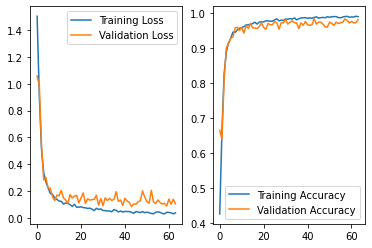

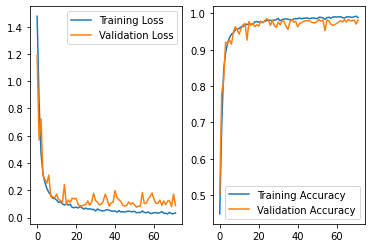

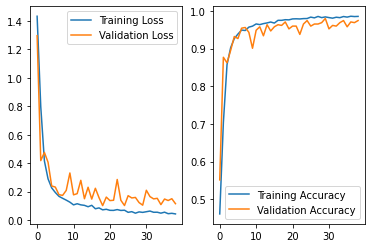

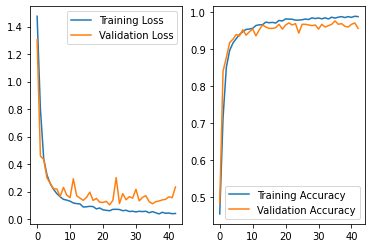

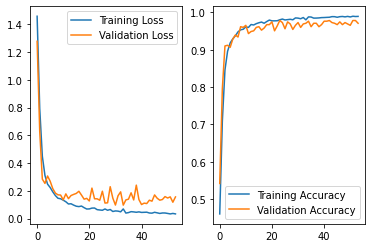

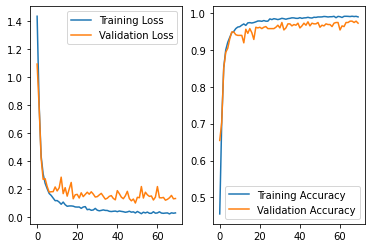

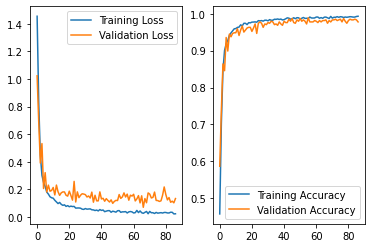

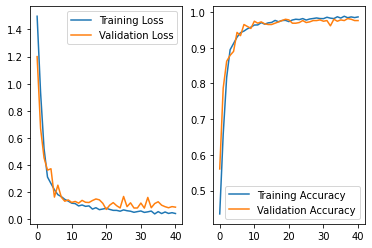

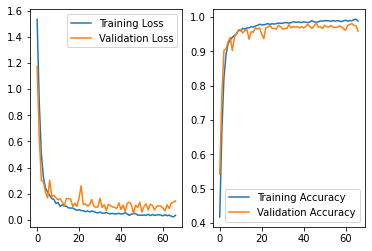

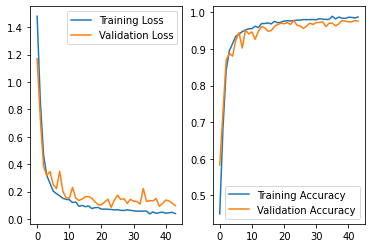

In [18]:
# Plot train val graphs
for i in range(n_split):
    _, axs = plt.subplots(ncols=2)
    df_history_info = pd.DataFrame(all_history[i].history) 


    sns.lineplot(data=df_history_info['loss'],ax=axs[0], label='Training Loss', legend='brief')
    sns.lineplot(data=df_history_info['val_loss'],ax=axs[0], label='Validation Loss', legend='brief')

    sns.lineplot(data=df_history_info['acc'],ax=axs[1], label='Training Accuracy', legend='brief')
    sns.lineplot(data=df_history_info['val_acc'],ax=axs[1], label='Validation Accuracy', legend='brief')

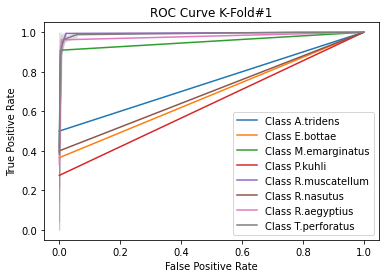

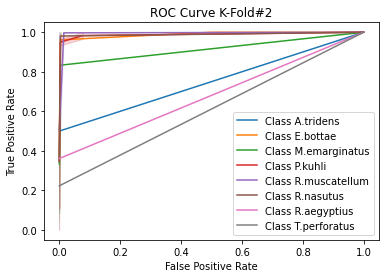

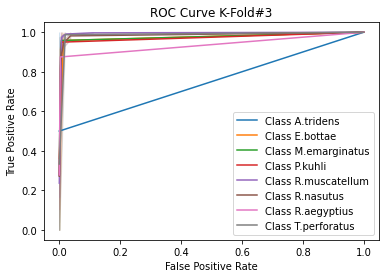

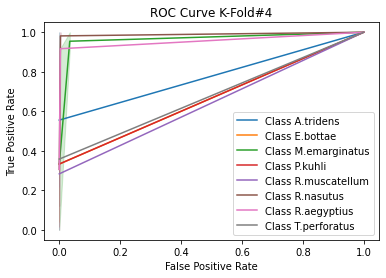

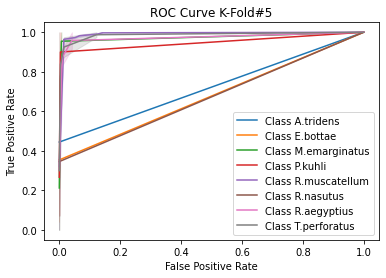

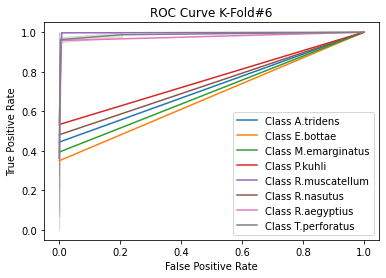

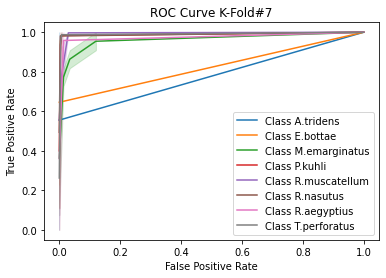

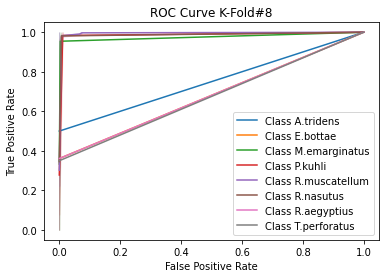

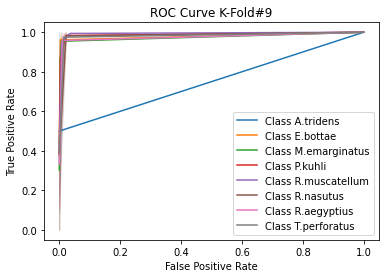

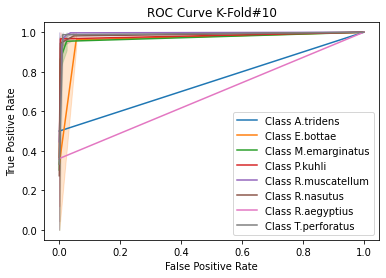

In [19]:
# Plot all K-Fold ROC curves

for i in range(n_split):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='False Positive Rate',ylabel='True Positive Rate', title='ROC Curve K-Fold#'+str(i+1))
    for j in range(n_classes):
        auc_val = auc(all_fpr[i][j], all_tpr[i][j])
        auc_val = np.around(auc_val,4)
        sns.lineplot(x=all_fpr[i][j],y=all_tpr[i][j],ax=axs, label='Class '+ getSpecies(j), legend='brief')
        

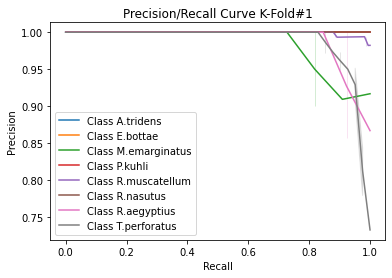

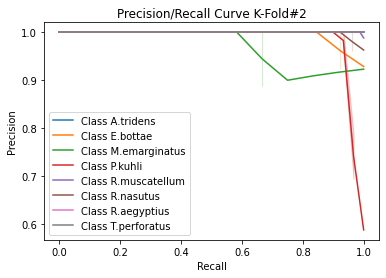

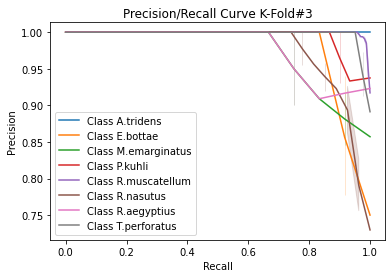

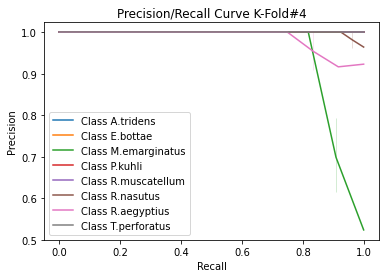

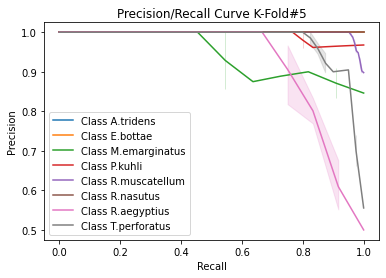

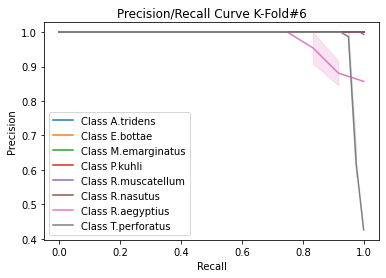

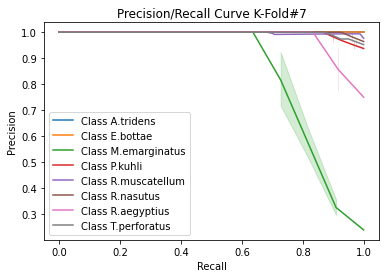

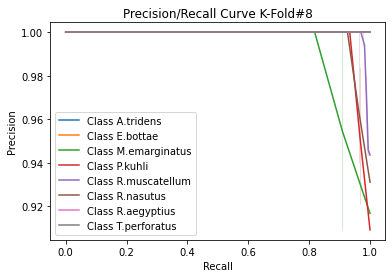

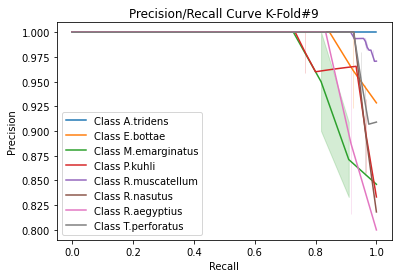

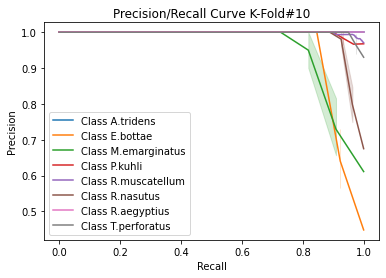

In [20]:
#Plot all K-Fold Precision/Recall curves
for i in range(n_split):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='Recall',ylabel='Precision', title='Precision/Recall Curve K-Fold#'+str(i+1))
    for j in range(n_classes):
        sns.lineplot(x=all_recall[i][j],y=all_precision[i][j],ax=axs, label='Class '+ getSpecies(j), legend='brief')

Confusion Matrix K-Fold #1

[[  2   0   0   0   0   0   0   0]
 [  0  13   0   0   0   0   0   0]
 [  0   0  10   0   0   0   1   0]
 [  0   0   0  29   0   0   0   0]
 [  0   0   0   0 164   0   0   2]
 [  0   0   0   0   0  27   0   0]
 [  0   0   1   0   0   0  12   0]
 [  0   0   0   0   2   0   0  39]]


Confusion Matrix K-Fold #2

[[  2   0   0   0   0   0   0   0]
 [  0  12   0   0   0   0   1   0]
 [  0   0  11   0   0   0   1   0]
 [  0   0   1  28   0   1   0   0]
 [  0   1   0   0 165   0   0   0]
 [  0   0   0   0   0  26   0   0]
 [  0   0   0   0   0   0  12   0]
 [  0   0   0   0   0   0   0  41]]


Confusion Matrix K-Fold #3

[[  2   0   0   0   0   0   0   0]
 [  0  11   0   0   0   1   0   0]
 [  0   0  11   0   1   0   0   0]
 [  0   0   0  28   1   1   0   0]
 [  0   0   0   0 165   0   1   0]
 [  0   1   1   2   0  23   0   0]
 [  0   0   0   0   0   0  12   0]
 [  0   0   0   0   1   0   0  40]]


Confusion Matrix K-Fold #4

[[  3   0   0   0   0   0   0   0]
 [  

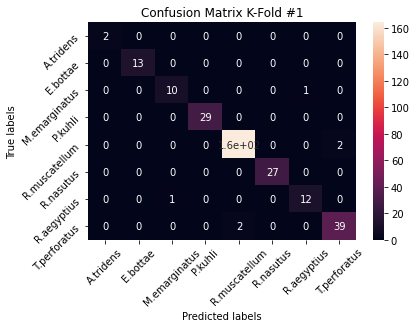

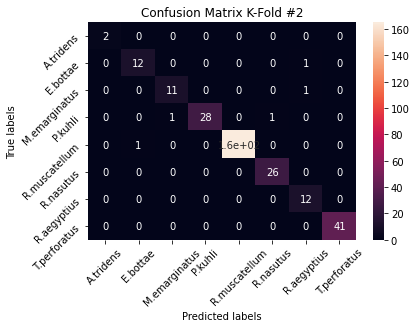

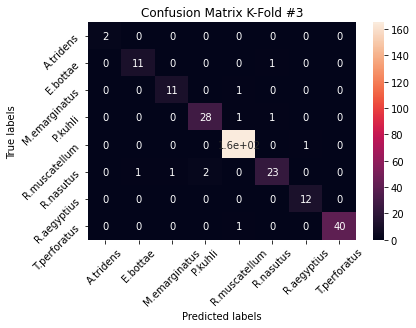

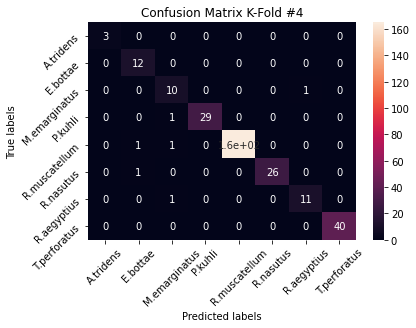

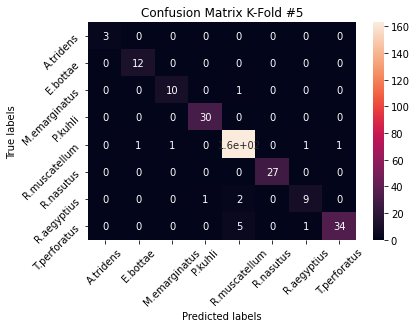

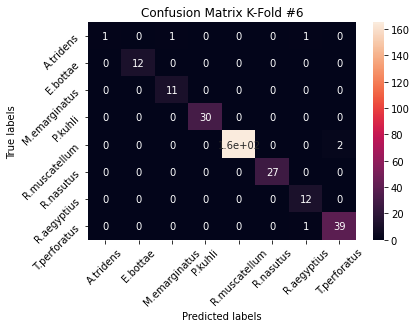

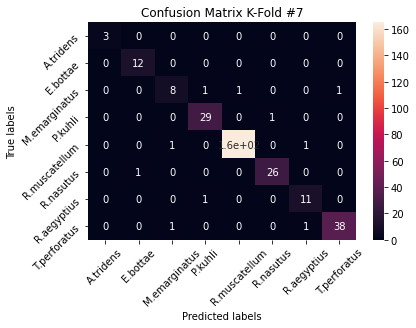

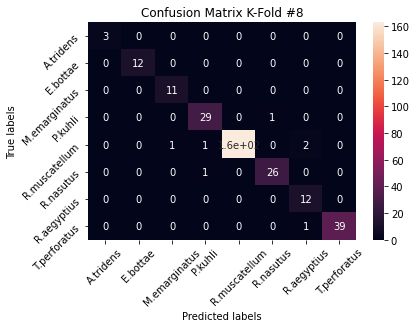

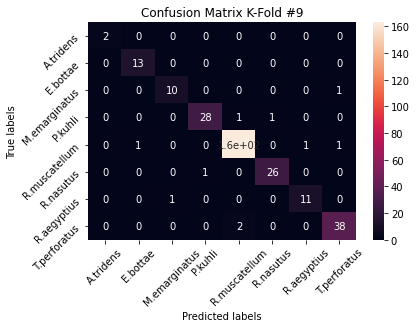

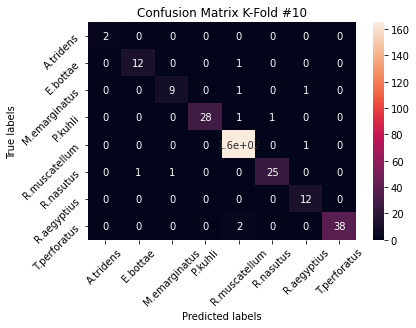

In [21]:
## Plot all K-Fold confusion matrices
import numpy as np
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt

# Create 1X 5 sub plots
# gs = gridspec.GridSpec(1,n_split)
figs=[]
for i in range(n_split):
    figs.append(plt.figure())
    
for i in range(n_split):
    print('Confusion Matrix K-Fold #'+ str(i+1)+"\n")
    print(all_cm[i])
    print("\n")
    
    ax=figs[i].add_subplot()
    sns.heatmap(all_cm[i], annot=True, ax = ax); #annot=True to annotate cells

    
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix K-Fold #'+ str(i+1)); 
    ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);

sum of all confuion matrices
 [[  23    0    1    0    0    0    1    0]
 [   0  121    0    0    1    1    1    0]
 [   0    0  101    1    4    0    4    2]
 [   0    0    2  288    3    6    0    0]
 [   0    4    4    1 1643    0    7    6]
 [   0    4    2    4    0  259    0    0]
 [   0    0    3    2    2    0  114    0]
 [   0    0    1    0   12    0    4  386]]

average of all confuion matrices
 [[  2   0   0   0   0   0   0   0]
 [  0  12   0   0   0   0   0   0]
 [  0   0  10   0   0   0   0   0]
 [  0   0   0  28   0   0   0   0]
 [  0   0   0   0 164   0   0   0]
 [  0   0   0   0   0  25   0   0]
 [  0   0   0   0   0   0  11   0]
 [  0   0   0   0   1   0   0  38]]


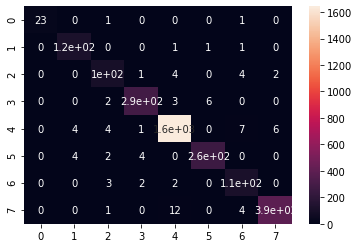

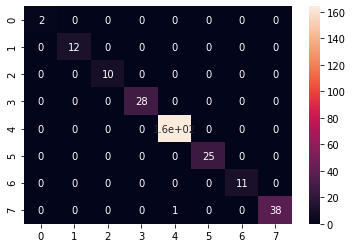

In [22]:
## plot macro cm

sum_all_cm=np.zeros((n_classes,n_classes)).astype('int64')
for i in range(n_split):
    sum_all_cm+=all_cm[i]
    
    
#plot 
figs=[]
for i in range(2):
    figs.append(plt.figure())
       
print("sum of all confuion matrices\n",sum_all_cm)
ax=figs[0].add_subplot()
sns.heatmap(sum_all_cm, annot=True, ax = ax);

avg_all_cm=np.divide(sum_all_cm,n_split).astype('int64')
print("\naverage of all confuion matrices\n",avg_all_cm)
ax=figs[1].add_subplot()
sns.heatmap(avg_all_cm, annot=True, ax = ax);

[[0.92 0.   0.04 0.   0.   0.   0.04 0.  ]
 [0.   0.98 0.   0.   0.01 0.01 0.01 0.  ]
 [0.   0.   0.9  0.01 0.04 0.   0.04 0.02]
 [0.   0.   0.01 0.96 0.01 0.02 0.   0.  ]
 [0.   0.   0.   0.   0.99 0.   0.   0.  ]
 [0.   0.01 0.01 0.01 0.   0.96 0.   0.  ]
 [0.   0.   0.02 0.02 0.02 0.   0.94 0.  ]
 [0.   0.   0.   0.   0.03 0.   0.01 0.96]]


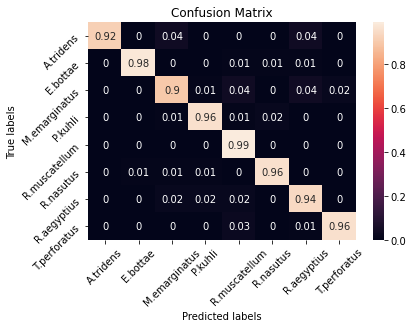

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


cm= sum_all_cm/ sum_all_cm.astype(np.float).sum(axis=1,keepdims = True)
cm = (np.around(cm,2))
print(cm)


labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']


ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);

<h2>Storing/Loading history and model to file</h2>

In [23]:
#Store History
hist_df = pd.DataFrame(history.history) 
hist_json_file = 'Model2-P-bats.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

In [25]:
#Load History 
history_info = pd.read_json('Model2-P-bats.json')

In [26]:
##Save Model
model.save('Model2-P-bats_trained.model') #Save the model

In [27]:
## Load Model
model = tf.keras.models.load_model('Model2V2-bats_trained.model') #Re load model

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
